In [262]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.compute as pc
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from multiprocessing import Pool
import json
from source import *
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

import scienceplots

plt.style.use(['science','ieee', 'grid'])

In [263]:
dataset = ds.dataset(list(Path(f"gen_data/").glob("*.parquet")), format="parquet")

In [264]:
scanner = dataset.scanner(batch_size=100_000)
for batch in scanner.to_batches():
    table = pa.Table.from_batches([batch])
    print(table.to_pandas().columns)
    break
del scanner

Index(['__experiment__', '__run__', '__event__', '__production__', 'pcm',
       'ecm', 'missedE', 'recM2_Ups', 'cmpmiss', 'cmthetamiss', 'fox_ups',
       'asymmetry', 'pBtag', 'theta_Btag', 'MBtag', 'rec_theta_Btag', 'idec0',
       'idec1', 'is0', 'N_KL', 'Miss_id_0', 'Miss_id_1', 'Bs_lik', 'N_KS',
       'theta_tau_0', 'p_tau_0', 'theta_tau_1', 'p_tau_1', 'p_tau_0_tagcm',
       'p_tau_1_tagcm', 'ang_taus', 'ang_taus_tagcm', 'ang_tau0_pmiss',
       'ang_tau1_pmiss', 'ang_tau1_ROE', 'ang_tau0_ROE', 'tau_d_0_0',
       'tau_d_1_0', 'tau_last_z_0', 'tau_last_r_0', 'tau_last_z_1',
       'tau_last_r_1', 'Istau0', 'Istau1', 'totalEnergyMC', 'E_gamma_in_ROE',
       'correct_nu_0', 'correct_nu_1', 'correct_gamma_0', 'correct_gamma_1',
       'lost_0', 'lost_1', 'PID_self_vs_0_tau0', 'PID_self_vs_1_tau0',
       'PID_self_vs_2_tau0', 'PID_self_vs_4_tau0', 'PID_self_vs_0_tau1',
       'PID_self_vs_1_tau1', 'PID_self_vs_2_tau1', 'PID_self_vs_4_tau1'],
      dtype='object')


In [265]:
decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]
mask = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("Bs_lik") > 0.0012) & (pc.field("N_KS") < 0.5)
mask_M = (pc.field("M0") > 5.347) &  (pc.field("M0") < 5.387) 
mask_is1 = pc.field("correct_nu_0") & pc.field("correct_nu_1") & pc.field("correct_gamma_0") & pc.field("correct_gamma_1") & pc.field("lost_0") & pc.field("lost_1") & pc.field("Miss_id_0") & pc.field("Miss_id_1")
mask_is0 = pc.field("is0") == 1
mask_miss_id = pc.field("Miss_id_0") & pc.field("Miss_id_1")
mask_lost_Kpi = pc.field("lost_0") & pc.field("lost_1")
mask_KS_veto = (pc.field("N_KS") == 0) & (pc.field("N_KL") == 0)

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\matve\AppData\Local\Temp\ipykernel_21400\2528252791.py:1: SyntaxWarning: invalid escape sequence '\m'
  decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]


In [266]:
mask_lep = ((pc.field("idec0") == 0) | (pc.field("idec0") == 1)) & ((pc.field("idec1") == 0) | (pc.field("idec1") == 1))
mask_pi = ((pc.field("idec0") == 2) & (pc.field("idec0") == 2))
mask_rho = ((pc.field("idec0") == 3) & (pc.field("idec0") == 3))
mask_pirho = ((pc.field("idec0") == 2) & (pc.field("idec1") == 3)) | ((pc.field("idec0") == 3) & (pc.field("idec1") == 2))
mask_pi_lep = ((pc.field("idec0") == 2)) & ((pc.field("idec1") == 0) | (pc.field("idec1") == 1)) | ((pc.field("idec0") == 0) | (pc.field("idec0") == 1)) & ((pc.field("idec1") == 2)) 
mask_rho_lep = ((pc.field("idec0") == 3)) & ((pc.field("idec1") == 0) | (pc.field("idec1") == 1)) | ((pc.field("idec0") == 0) | (pc.field("idec0") == 1)) & ((pc.field("idec1") == 3))

In [267]:
decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\matve\AppData\Local\Temp\ipykernel_21400\1033810642.py:1: SyntaxWarning: invalid escape sequence '\m'
  decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]


In [268]:
mods_cut = {'lep': [mask_lep, 'lep', 'e / \\mu', 0.15, 0.025],
        'pipi': [mask_pi, 'pirho', '\\pi \\pi', 0.15, 0.025],
        'rhorho': [mask_rho, 'pirho', '\\rho \\rho', 0.15, 0.025],
        'pirho': [mask_pirho, 'pirho', '\\pi \\rho', 0.15, 0.025],
        'pilep': [mask_pi_lep, 'pirho_lep', '\\pi \\ell', 0.6, 0.15],
        'rholep': [mask_rho_lep, 'pirho_lep', '\\rho \\ell', 0.2, 0.05],}

In [269]:
current_mod = 'lep'

In [270]:
import json
with open(f"models/columns_and_fom_{mods_cut[current_mod][1]}.json", "r") as f:
    data_to_save = json.load(f)
columns = data_to_save["columns"]
FoM = data_to_save["FoM"]

In [271]:
data = get_values(dataset, columns + ['E_gamma_in_ROE', 'MBtag'], filter_mask=(mask & mods_cut[current_mod][0]))

Total data size: 0.06 MB


In [272]:
from xgboost import XGBClassifier
import json
model = XGBClassifier()
model.load_model(f"models/bdt_model_{mods_cut[current_mod][1]}.json")
with open(f"models/columns_and_fom_{mods_cut[current_mod][1]}.json", "r") as f:
    data_to_save = json.load(f)
columns = data_to_save["columns"]
FoM = 0
FoM = data_to_save["FoM"][current_mod]

In [273]:
X_new = data[columns]

bdt_scores = model.predict_proba(X_new)[:, 1] 

data["bdt_score"] = bdt_scores

selected_mask = data["bdt_score"] > FoM

selected_data = data[selected_mask]

In [274]:
BS0 = 5.366691

In [275]:
a_x, b_x = 0, 1.2
a_y, b_y = 5.25, 5.5

wbin_x = mods_cut[current_mod][3]
wbin_y = mods_cut[current_mod][4]

bins_x = np.linspace(a_x, b_x, int((b_x - a_x) // wbin_x + 2))
bins_y = np.linspace(a_y, b_y, int((b_y - a_y) // wbin_y + 2))

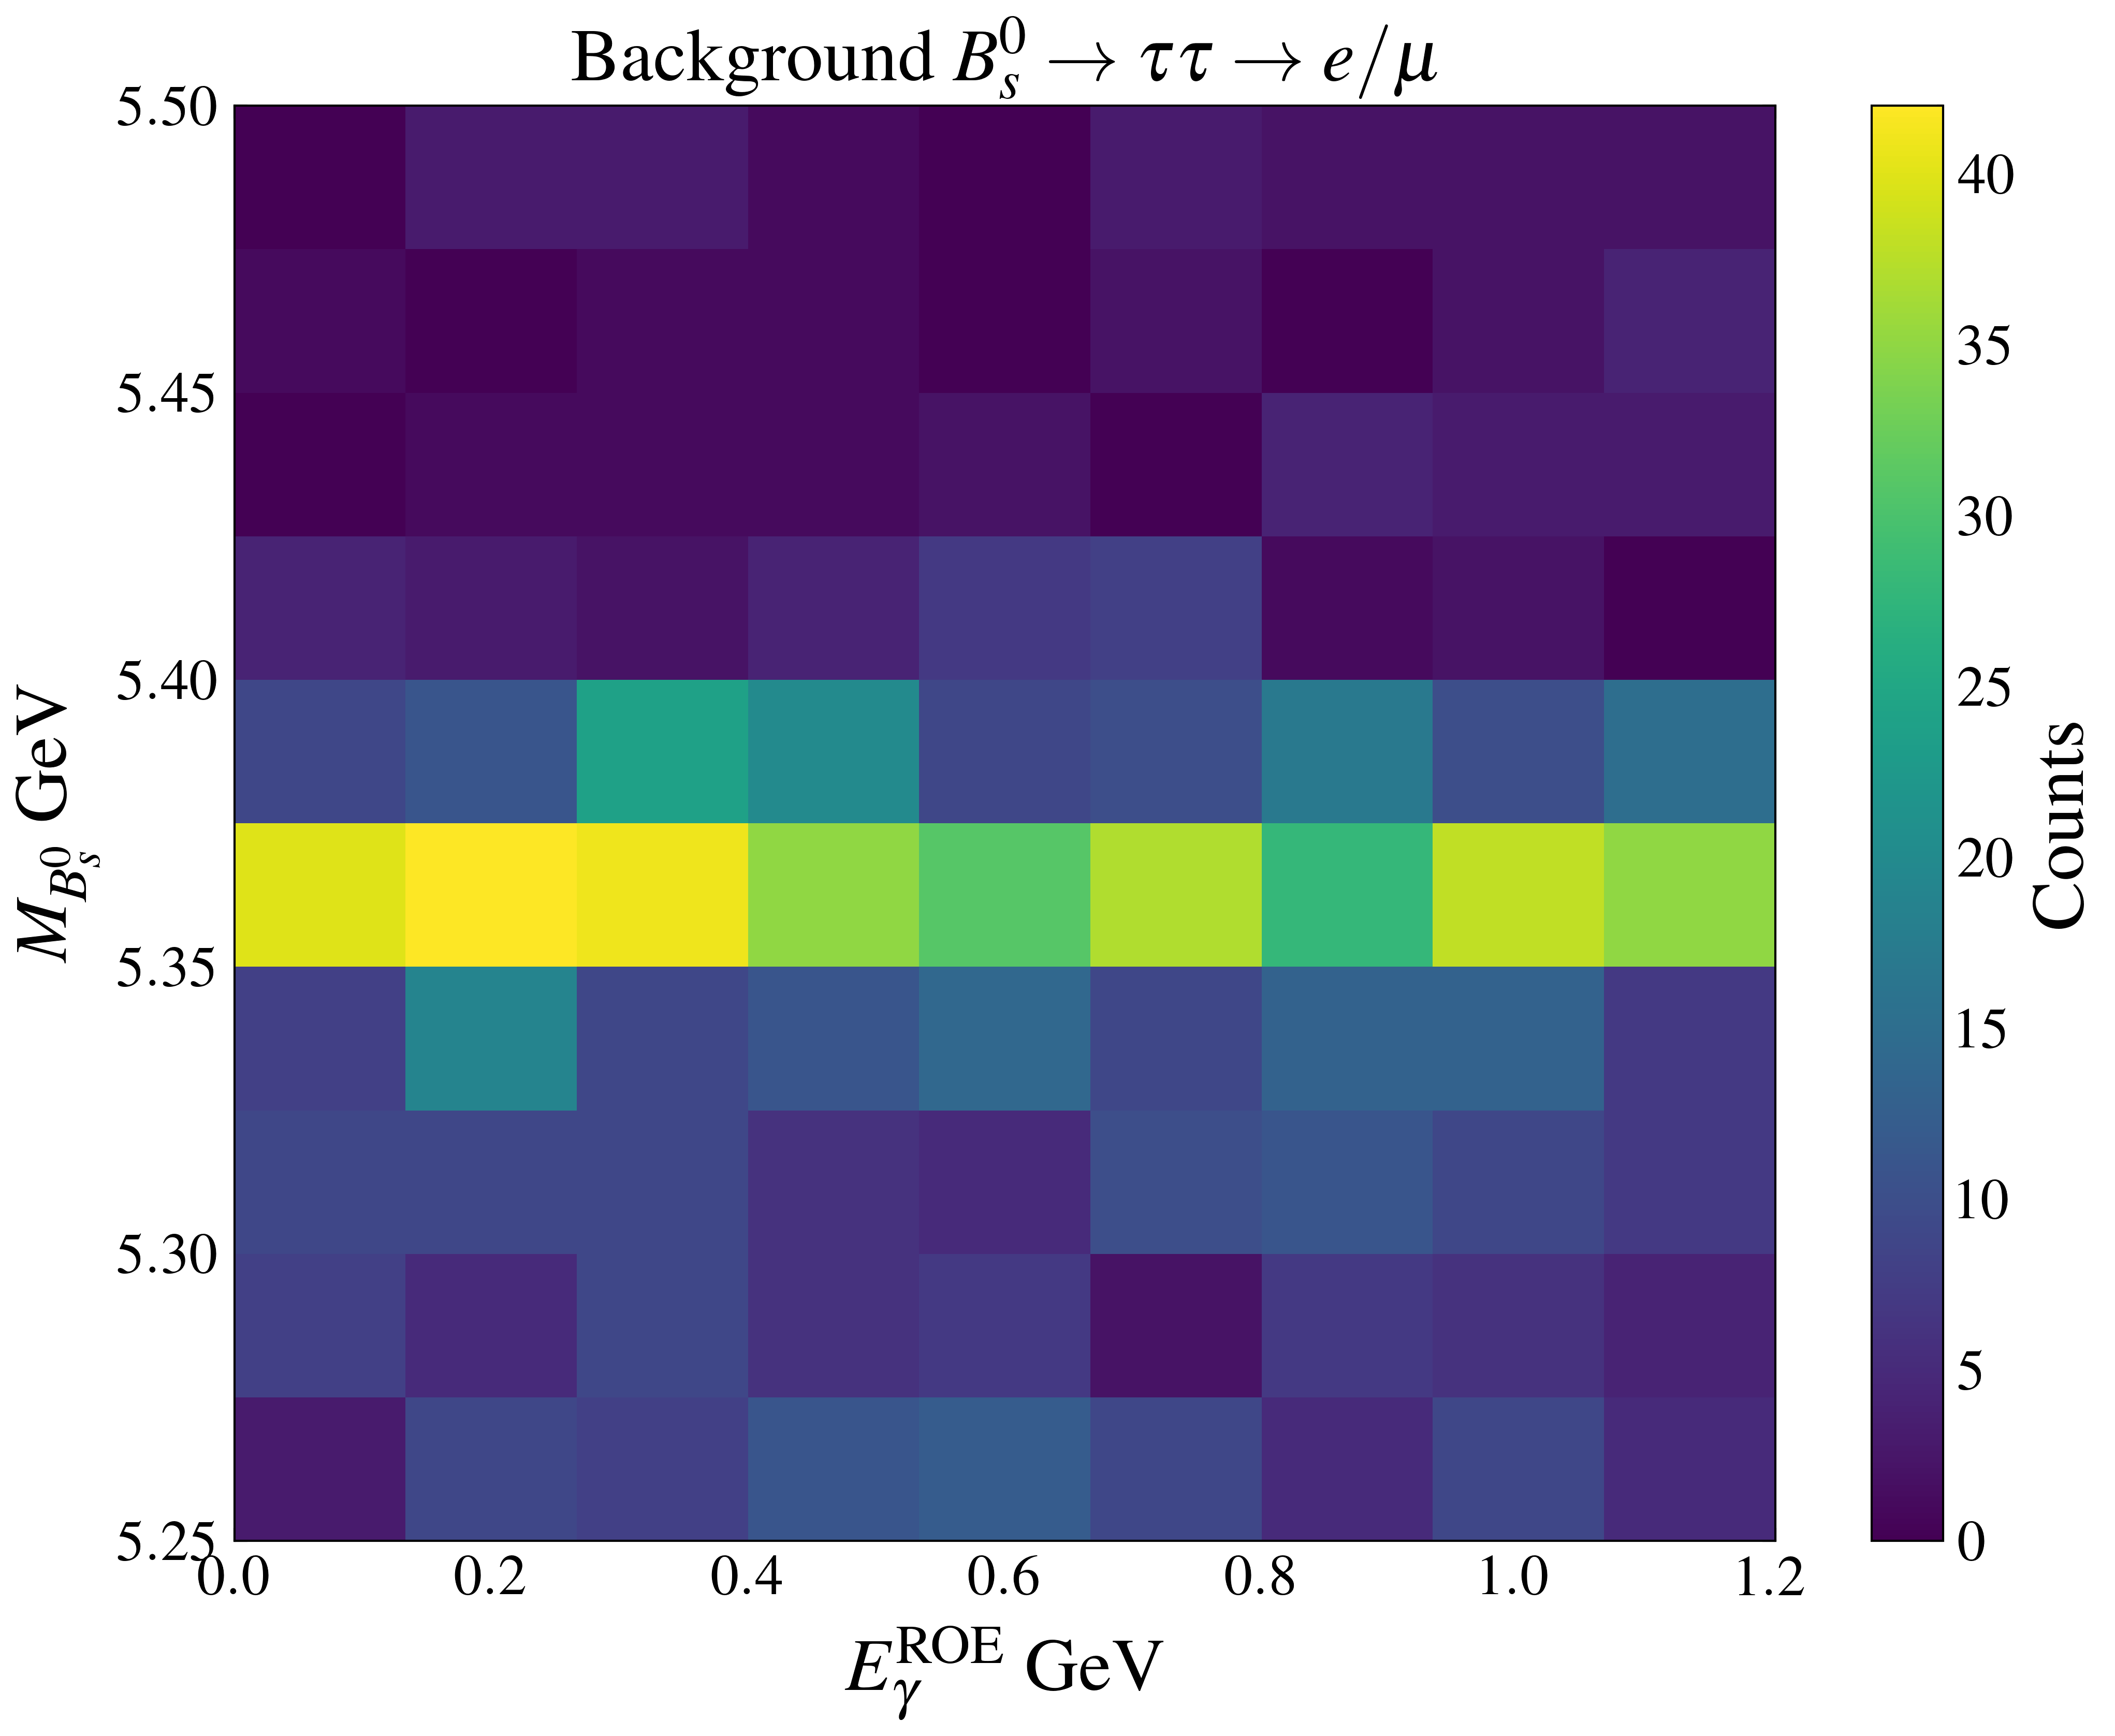

In [276]:
values = selected_data[["E_gamma_in_ROE", "MBtag"]].values

counts, _ = np.histogramdd(values, bins=(bins_x, bins_y))
bin_centers = [0.5 * (b[:-1] + b[1:]) for b in (bins_x, bins_y)]
bin_centers = np.meshgrid(*bin_centers, indexing='ij')

plt.figure(figsize=(8, 6))
pmesh = plt.pcolormesh(*bin_centers, counts)
plt.xlabel(r"$E_\gamma^{\mathrm{ROE}}\ \mathrm{GeV}$")
plt.ylabel(r"$M_{B_s^0}\ \mathrm{GeV}$")
plt.title(rf"Background $B_s^0 \to \tau \tau \to {mods_cut[current_mod][2]}$")
plt.colorbar(pmesh, label="Counts")
plt.savefig(f"output/bg_E_ROE_M_Bs_{current_mod}.pdf", dpi=700)
plt.show()

In [277]:
hist = hist_approx()
hist.put_hist(bin_centers, counts)

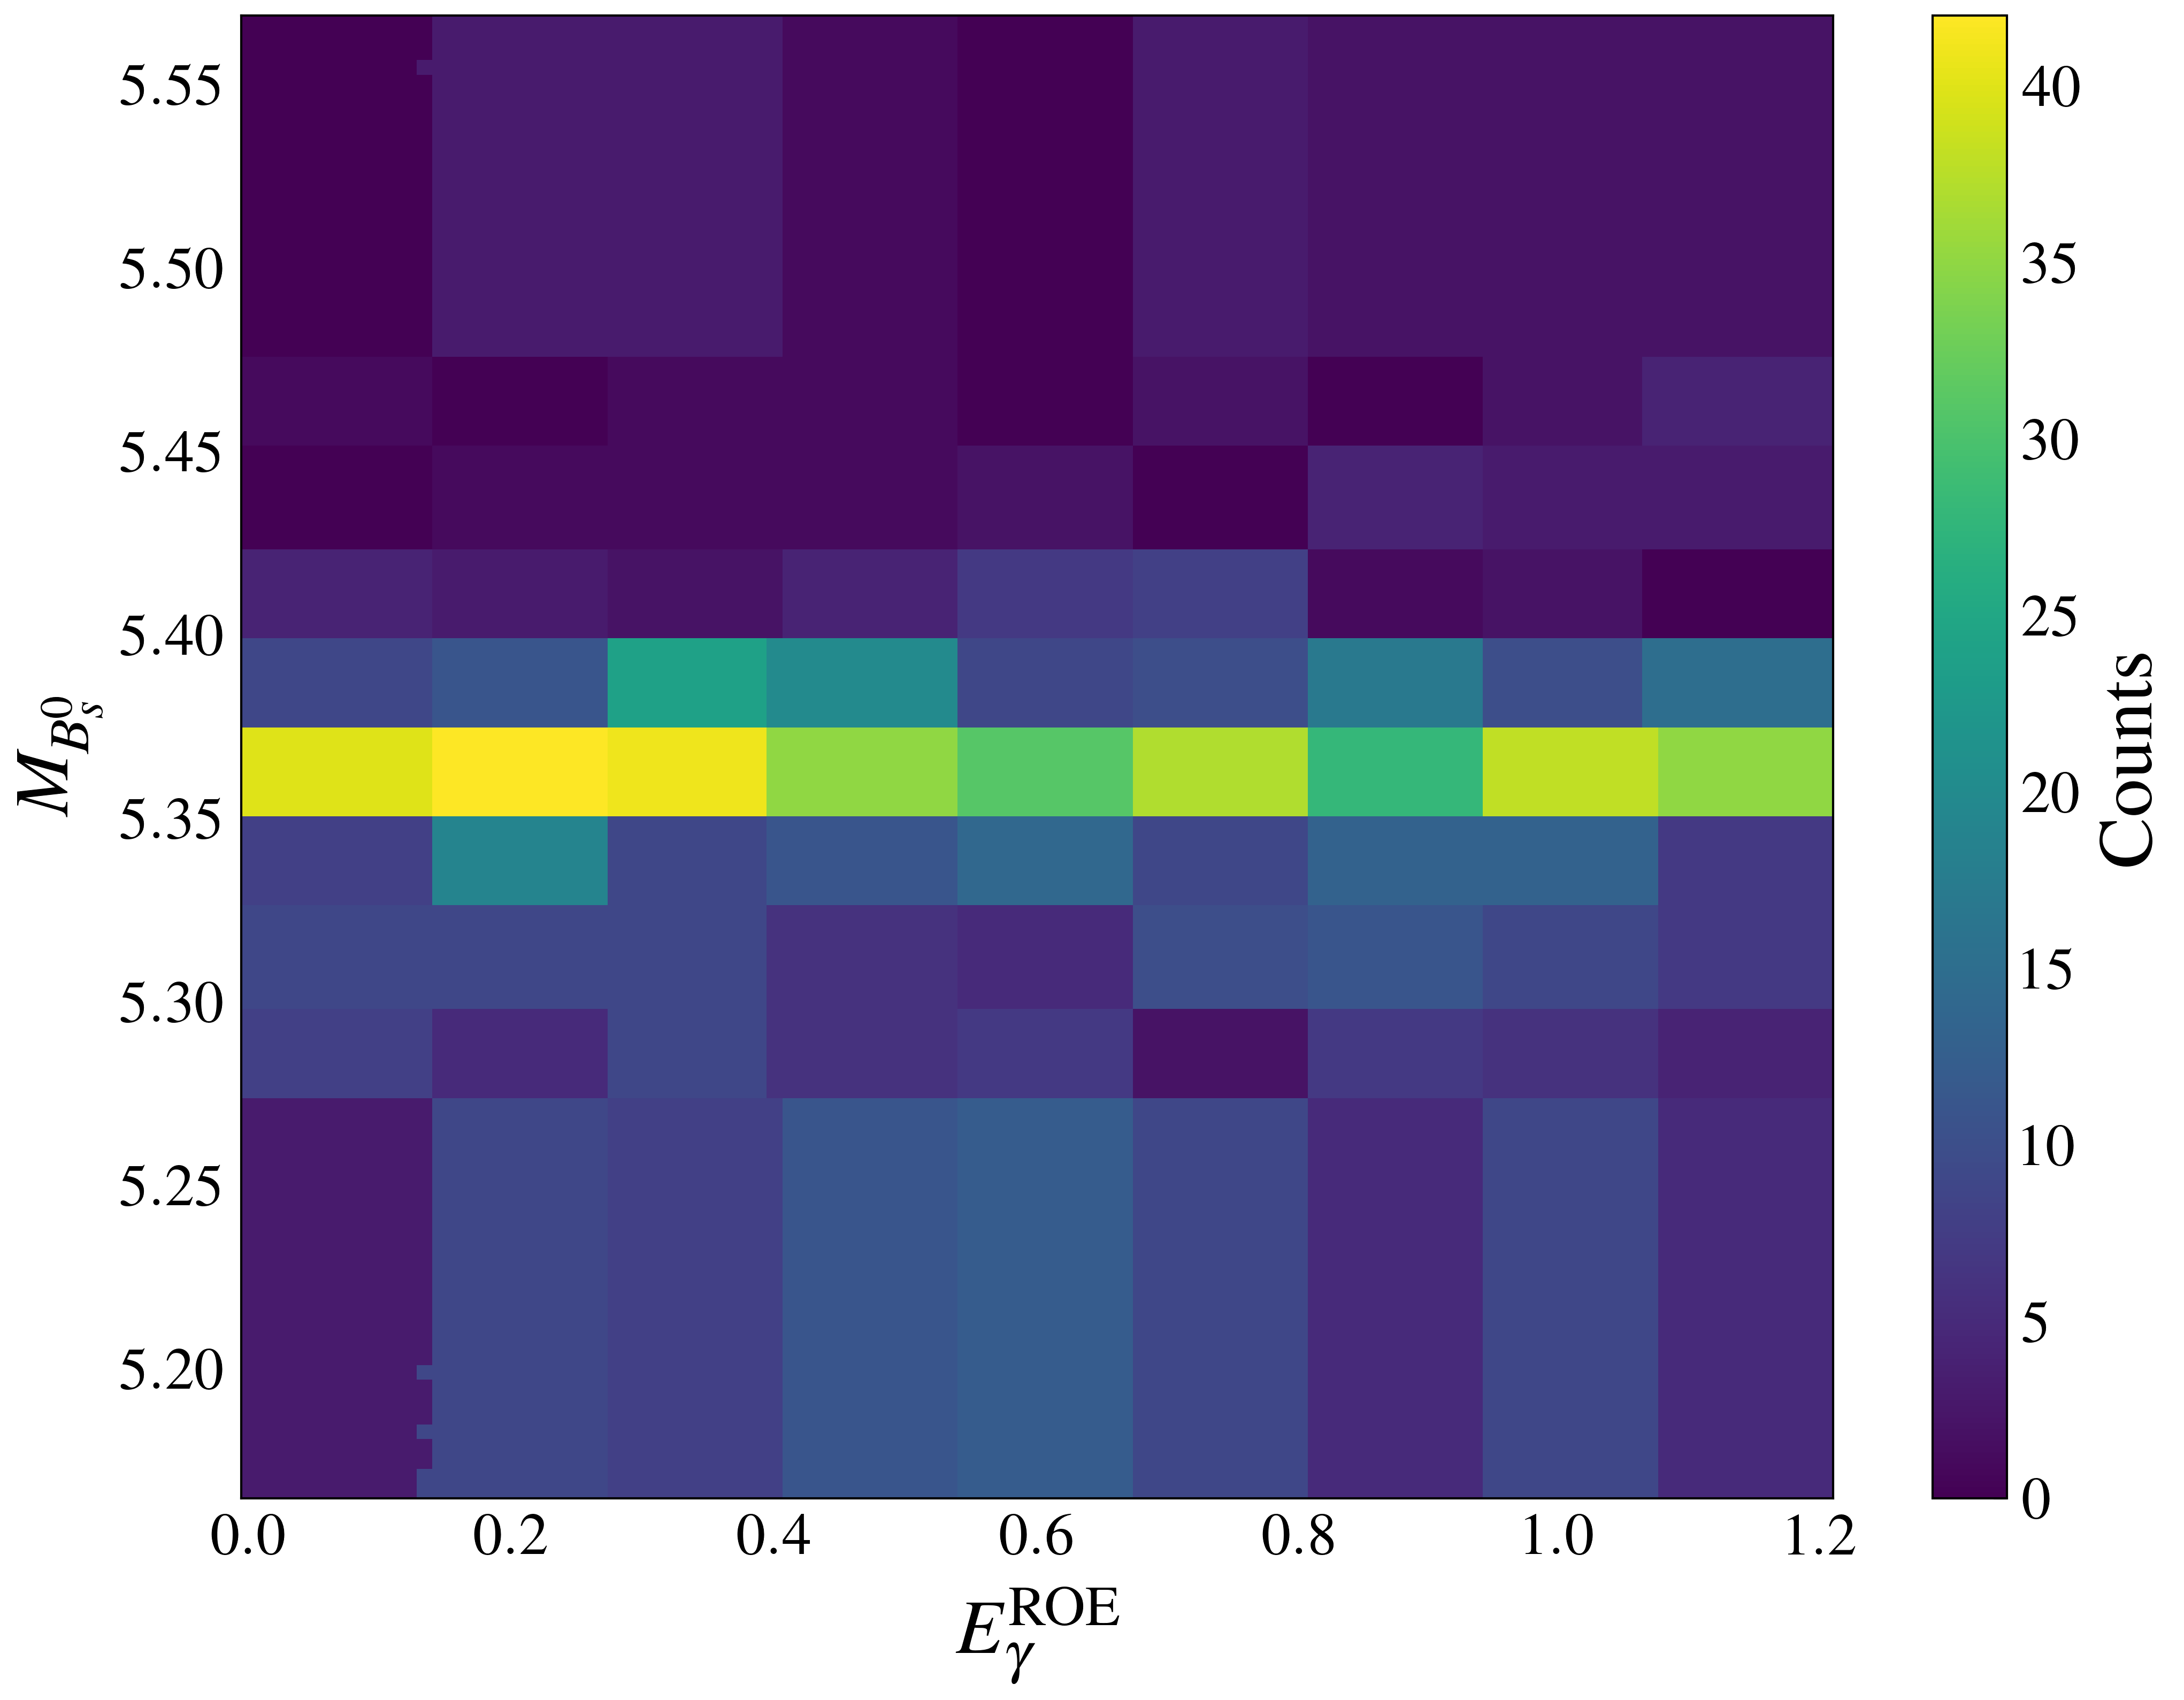

In [278]:
x = np.linspace(0, 1.2, 100)
y = np.linspace(BS0 - 0.2, BS0 + 0.2, 100)
X, Y = np.meshgrid(x, y, indexing='ij')
val = hist.get_counts([X,Y])

plt.figure(figsize=(8, 6))
pmesh = plt.pcolormesh(X, Y, val)
plt.xlabel(r"$E_\gamma^{\mathrm{ROE}}$")
plt.ylabel(r"$M_{B_s^0}$")
plt.colorbar(pmesh, label="Counts")
plt.show()

In [279]:
hist.save_hist(f"shapes/bg_{current_mod}.json")

In [280]:
filename = f"quantity/N_{current_mod}.json"

new_data = {"N_bg": selected_data.shape[0]}

if os.path.exists(filename):
    with open(filename, "r", encoding="utf-8") as f:
        try:
            data = json.load(f)
        except json.JSONDecodeError:
            data = {}
else:
    data = {}

data.update(new_data)

with open(filename, "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

print(f"Файл '{filename}' обновлён или создан заново.")

Файл 'quantity/N_lep.json' обновлён или создан заново.
